## DSCI 552 - PS 2 - Logistic Regression Classification
### "Whether or not patient should receive a treatment based on medical data"
### Deadline: **Thursday, February 25, 2021, 10 A.M PT**

I want you to design a model, that can **classify if a certain treatment is recommended for the patient or not**.
Additionally, there are 6 additional features that we can use. However, they are really expensive and difficult to collect. I
want you to assess how useful they are. 

Hint: Your boss called your task “proof-of-concept”, but in fact, the nature of that assignment is the same
as the last time. You are asked to **train a classification model and you must measure how good that model
is**. Additionally, you must give **recommendations which features are important to collect**. You should look
at all variables, but at minimum, you should **test the importance of TestA, TestB, GeneC, GeneD, GeneE and GeneF.**.

Your Technical Manager said: “This time it really matters, that your model has a good
performance. If we can show that our model makes less mistakes than a human doctor, it would
be a big deal. Describe exactly how you tested your model. They are really going to look at that
section. Additionally, similar to the last time, the interpretability of the model is very important.
You should **restrict yourself to logistic regression.**

Hint: Remember, that accuracy alone, is not a good measure. We care both, about **accuracy, precision
and F1-score**. Report also **false positive and false negative**. To choose a right model, you can use for
example the **AUC score**. It is ok (it's even expected) that you will do some **feature engineering**. You can
also try to add **regularization to your logistic regression** and test if it helps you or not. To show that the
model can be interpreted, you can **identify and explain the most important relations between the variables
and the expected outcome** (e.g., how the probability that the treatment is recommended changes with
age? Or gender?).

Dataset: Patient Data
    
Binary Response: 
    $$ Y_i = 0  \text{  , if treatment is NOT recommended for patient i} $$
    $$ Y_i = 1 \text{  , if treatment is recommended for patient i }$$

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy as sp 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant as add_constant

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor

## modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

## metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score

## import custom function to get feature names
from helper import get_feature_names

In [2]:
df = pd.read_csv('../data/ps2_public.csv')

In [3]:
df.head(3)

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,64,103.820809,non-female,negative,False,4.334376,0.324374,not active,1,1,0
1,0,52,107.071369,female,negative,False,0.361847,-0.213014,active,1,0,0
2,1,55,113.116130,female,positive,False,3.611842,-0.071740,not active,0,0,1


In [4]:
df.shape

(7500, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   treatment       7500 non-null   int64  
 1   age             7500 non-null   int64  
 2   blood_pressure  7500 non-null   float64
 3   gender          7500 non-null   object 
 4   blood_test      7500 non-null   object 
 5   family_history  4893 non-null   object 
 6   TestA           7500 non-null   float64
 7   TestB           7500 non-null   float64
 8   GeneC           7500 non-null   object 
 9   GeneD           7500 non-null   int64  
 10  GeneE           7500 non-null   int64  
 11  GeneF           7500 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 703.2+ KB


In [6]:
df.describe()

,treatment,age,blood_pressure,TestA,TestB,GeneD,GeneE,GeneF
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.552533,59.978000,101.023910,3.983448,-0.000590,0.549467,0.550667,0.551200
std,0.497266,8.100115,36.128945,4.162343,0.171500,0.497580,0.497459,0.497405
min,0.000000,29.000000,-999.000000,-11.699344,-0.288422,0.000000,0.000000,0.000000
25%,0.000000,54.000000,91.802997,1.117443,-0.134452,0.000000,0.000000,0.000000
50%,1.000000,60.000000,99.814330,3.991237,-0.027296,1.000000,1.000000,1.000000
75%,1.000000,65.000000,110.095869,6.784449,0.101578,1.000000,1.000000,1.000000
max,1.000000,93.000000,157.471226,21.386412,0.740719,1.000000,1.000000,1.000000


In [7]:
## class proportions
df['treatment'].value_counts()

1    4144
0    3356
Name: treatment, dtype: int64

In [8]:
## check for missing vals
df.isnull().sum()

treatment            0
age                  0
blood_pressure       0
gender               0
blood_test           0
family_history    2607
TestA                0
TestB                0
GeneC                0
GeneD                0
GeneE                0
GeneF                0
dtype: int64

## Data preparation

In [9]:
## Deal with missing values
## remove fam history col
df.dropna(axis=1, inplace=True)

In [10]:
## Data Exploration
def make_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(15,12))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=30, ax=ax)
        ax.set_title(feature + " Distribution")
    fig.tight_layout()  
    plt.savefig('../images/ps2_histgrams.png')

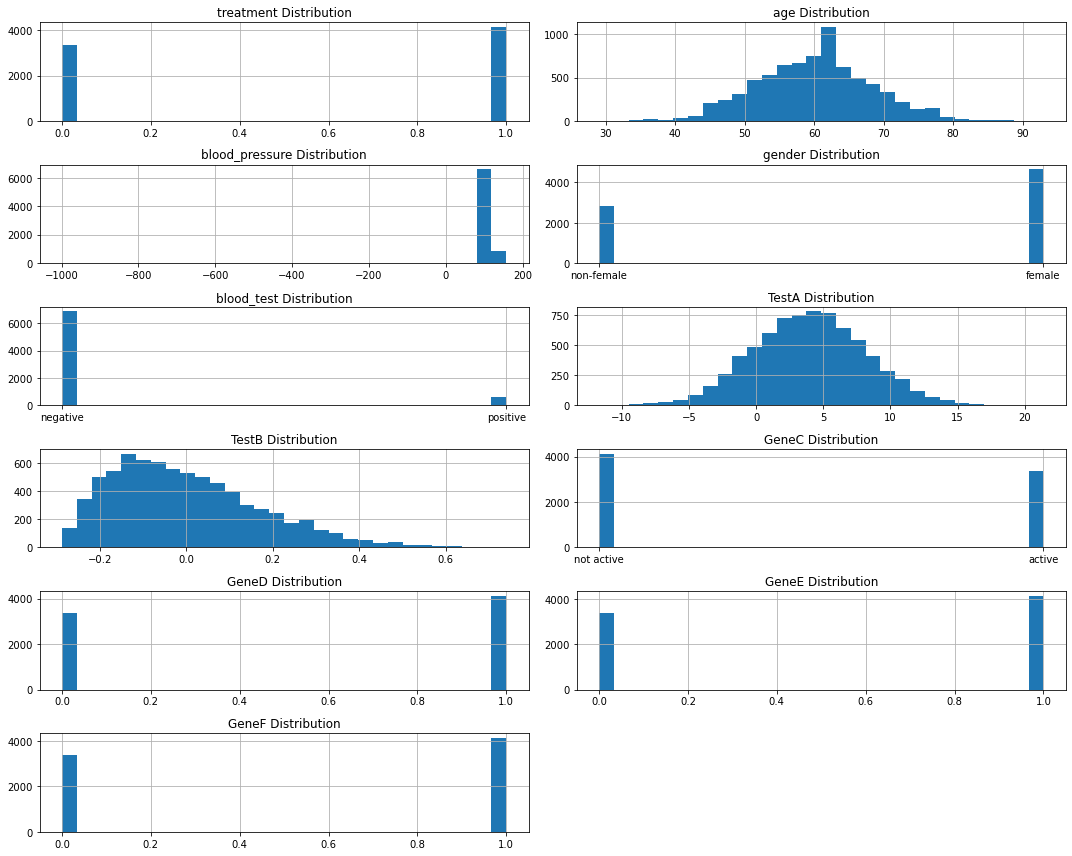

In [11]:
make_histograms(df,df.columns,6,2)

We can see some variables (e.g. blood pressure) are very skewed and need to be corrected via methods such as outlier removal.

In [13]:
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(cat_cols)
print(num_cols)

Index(['gender', 'blood_test', 'GeneC'], dtype='object')
Index(['treatment', 'age', 'blood_pressure', 'TestA', 'TestB', 'GeneD',
       'GeneE', 'GeneF'],
      dtype='object')


<Figure size 720x720 with 0 Axes>

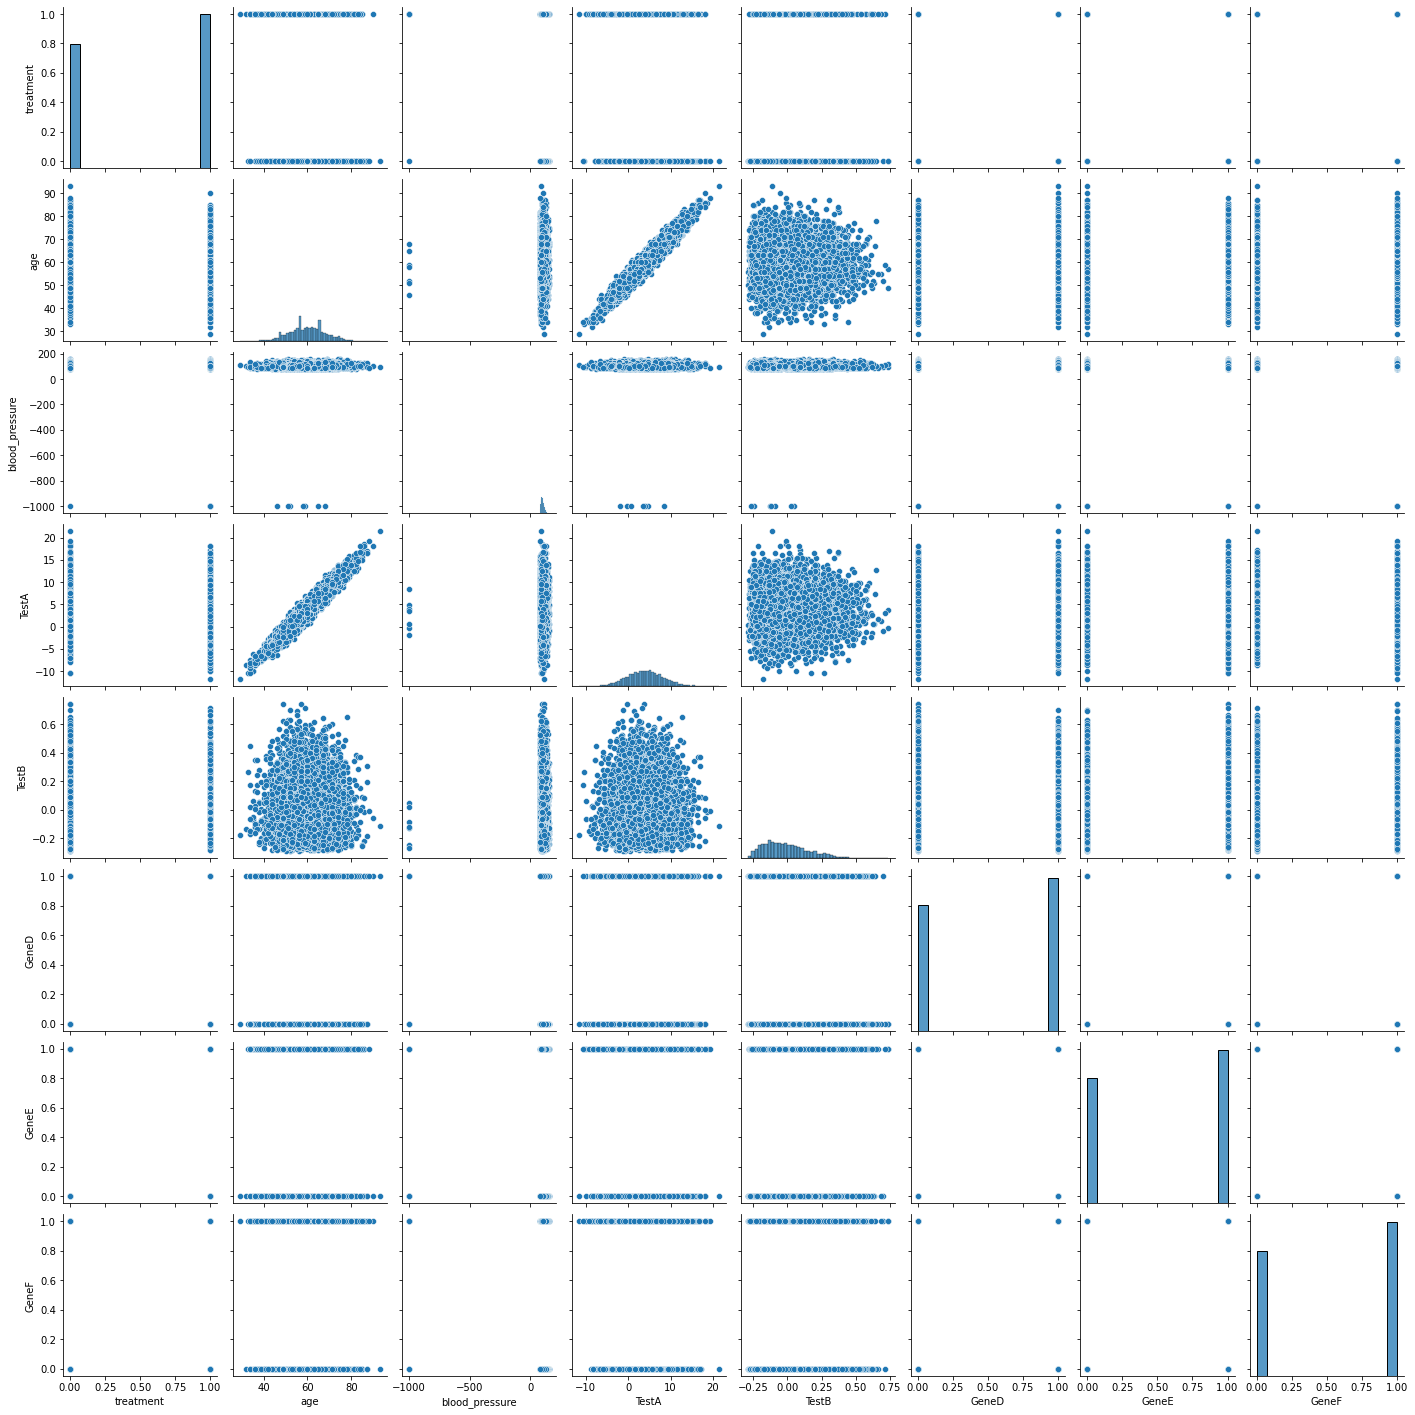

In [13]:
## Detect multicollinearity by first plotting pairwise features
plt.figure(figsize=(10,10))
sns.pairplot(df[num_cols])

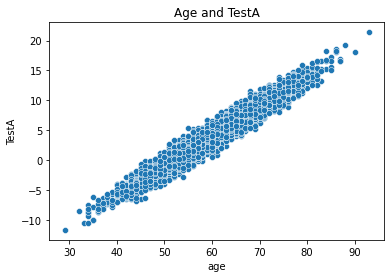

In [16]:
## example of multicollinearity
plt.title('Age and TestA')
sns.scatterplot(x='age', y='TestA',data=df)
plt.savefig("../images/multicoll_1.png")

In [17]:
## Detect multicollinearity uisng VIF
num_df = df[num_cols]
vifs = pd.DataFrame() 
vifs["feature_name"] = num_df.columns 
vifs["VIF"] = [variance_inflation_factor(num_df.values, i) for i in range(len(num_df.columns))] 
vifs

,feature_name,VIF
0,treatment,2.322547
1,age,19.591299
2,blood_pressure,8.763100
3,TestA,3.268509
4,TestB,1.008384
5,GeneD,2.214492
6,GeneE,2.225922
7,GeneF,2.226406


In [18]:
## Drop columns that are highly correlated
to_drop = ['age', 'blood_pressure']
df.drop(to_drop, axis=1, inplace=True)

In [19]:
df.head(3)

,treatment,gender,blood_test,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,non-female,negative,4.334376,0.324374,not active,1,1,0
1,0,female,negative,0.361847,-0.213014,active,1,0,0
2,1,female,positive,3.611842,-0.071740,not active,0,0,1


In [20]:
## Handle outliers
## Find the outliers using IQR method (outside of the IQR is considered outlier)
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3 - q1
print(IQR)

treatment    1.000000
TestA        5.667006
TestB        0.236031
GeneD        1.000000
GeneE        1.000000
GeneF        1.000000
dtype: float64


In [21]:
# Remove outliers
df2 = df[~((df < (q1 - 1.5 * IQR)) |(df > (q3 + 1.5 * IQR))).any(axis=1)]
df.shape, df2.shape   # dropped 150 rows

((7500, 9), (7350, 9))

In [22]:
cat_cols2 = df2.select_dtypes(include=['object']).columns
num_cols2 = df2.select_dtypes(include=['float64', 'int64']).columns
print(cat_cols2)
print(num_cols2)

Index(['gender', 'blood_test', 'GeneC'], dtype='object')
Index(['treatment', 'TestA', 'TestB', 'GeneD', 'GeneE', 'GeneF'], dtype='object')


In [24]:
## Transform pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols2),
    ("categorical", OneHotEncoder(), cat_cols2)
])

arr = pipeline.fit_transform(df2)  
print(arr.shape) 
feature_names = get_feature_names(pipeline)

(7350, 12)


In [26]:
X = arr[:,1:]
y = arr[:,0]
X.shape, y.shape

((7350, 11), (7350,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling

In [34]:
## First tests using defalt Log Reg 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"The accuracy score is {acc*100:0.4f}%")

The accuracy score is 73.4014%


In [111]:
# ## Craete confusion matrix of pos/neg predicted and actual
# cm_data = confusion_matrix(y_test, y_pred)
# confusionmatrix = pd.DataFrame(data=cm_data,columns=['Predicted: 0','Predicted: 1'], index=['Actual: 0', 'Actual: 1'])

# plt.figure(figsize = (8,6))
# plt.title("Confusion Matrix")
# sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap="Blues")

Feature importances:

In [36]:
logreg.coef_

array([[-0.12558307, -1.05329653, -0.0698345 , -0.25652398, -0.12671998,
         1.10044026, -1.09876542,  0.16103161, -0.15935677,  0.01176438,
        -0.01008955]])

In [37]:
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f1)  ## we want high f1 score

0.7730702263493906


In [39]:
roc_auc_score(y_test, y_pred)

0.723811073019646

# Regularized Logistic regression

In [40]:
## Try more regularized Log Reg

penalty = ['l1', 'l2', 'elasticnet', 'none']
## NOTE: only specific solvers work with specific penalties
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

## test diff values of C
C_list = list(np.linspace(0.1, 1.0, 10))
print(C_list)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0]


In [41]:
# 10 fold cv for OLS using sklearn
def list_logreg_models(solver='lbfgs', penalty='l2'):
    print(f"Using '{solver}' solver and '{penalty}' penalty")
    models = dict()
    models['log_reg_default'] = LogisticRegression(penalty=penalty, solver=solver)
    C_list = list(np.linspace(0.1, 1.0, 10))
    for c in C_list:
        models['log_reg_' + str(c)] = LogisticRegression(C=c, penalty=penalty, solver=solver)
    return models
 
def eval_one_model(X, y, model, folds, metric):
	scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=folds, n_jobs=1)
	return scores

def eval_multi_models(X, y, models, folds=10, metric='f1'):   
    results = {}
    print(f"Evaluate using '{metric}' metric")
    for name, model in models.items():
        scores = eval_one_model(X, y, model, folds, metric)
        if scores is not None:
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
#             print(f'{name}: Mean {metric}:{mean_score:.3f}')
    return results

In [42]:
## Using default solver and penalty l2
my_models = list_logreg_models()
results = eval_multi_models(X, y, my_models)
# results = eval_multi_models(X, y, my_models, metric='accuracy')
mean_results = {name: np.abs(np.round(np.mean(arr), 4)) for name, arr in results.items()}
## sort results with 'best' models first (highest f1 score)
sorted(mean_results.items(), key=lambda x: x[1], reverse=True)

Using 'lbfgs' solver and 'l2' penalty
Evaluate using 'f1' metric


[('log_reg_0.2', 0.7757),
 ('log_reg_0.5', 0.7757),
 ('log_reg_0.6', 0.7757),
 ('log_reg_0.4', 0.7756),
 ('log_reg_0.7000000000000001', 0.7756),
 ('log_reg_default', 0.7755),
 ('log_reg_0.30000000000000004', 0.7755),
 ('log_reg_0.8', 0.7755),
 ('log_reg_0.9', 0.7755),
 ('log_reg_1.0', 0.7755),
 ('log_reg_0.1', 0.7749)]

In [43]:
## Try different solvers and penalties

## E.g. saga with l1 penalty (BEST so far in both f1 and accuracy)
my_models = list_logreg_models('saga', 'l1')

## saga with l2
# my_models = list_logreg_models('saga', 'l2')  

## newton-cg
# my_models = list_logreg_models('newton-cg', 'l2')

## sag
# my_models = list_logreg_models('sag', 'l2')

results = eval_multi_models(X, y, my_models, metric='f1')
# results = eval_multi_models(X, y, my_models, metric='accuracy')
mean_results = {name: np.abs(np.round(np.mean(arr), 4)) for name, arr in results.items()}
## sort results with 'best' models first (highest f1 score)
sorted(mean_results.items(), key=lambda x: x[1], reverse=True)

Using 'saga' solver and 'l1' penalty
Evaluate using 'f1' metric


[('log_reg_0.1', 0.7762),
 ('log_reg_0.30000000000000004', 0.7761),
 ('log_reg_0.2', 0.776),
 ('log_reg_0.4', 0.7759),
 ('log_reg_0.5', 0.7758),
 ('log_reg_0.6', 0.7758),
 ('log_reg_0.7000000000000001', 0.7757),
 ('log_reg_0.8', 0.7757),
 ('log_reg_0.9', 0.7757),
 ('log_reg_default', 0.7756),
 ('log_reg_1.0', 0.7756)]

my chosen model is saga solver, l1 penalty for regularization, and C=0.1

# Final Model
After selecting best hyperparams using CV, output the final model and its results on the test set

In [53]:
solver = 'saga'
penalty = 'l1'
C = 0.1
final_model = LogisticRegression(solver=solver, penalty=penalty, C=C)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

In [88]:
y_pred_probs = final_model.predict_proba(X_test)

In [89]:
y_pred_probs

array([[0.41020493, 0.58979507],
       [0.34975983, 0.65024017],
       [0.75589047, 0.24410953],
       ...,
       [0.72278624, 0.27721376],
       [0.64108475, 0.35891525],
       [0.15742875, 0.84257125]])

In [109]:
print("Final Model Metrics")
print("-"*20)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_final):0.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):0.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):0.4f}")
print(f"F1: {f1_score(y_test, y_pred_final):0.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_final):0.4f}")

## Craete confusion matrix data of pos/neg predicted and actual
cm_data = confusion_matrix(y_test, y_pred_final)
confusionmatrix = pd.DataFrame(data=cm_data,columns=['Predicted: 0','Predicted: 1'], index=['Actual: 0', 'Actual: 1'])

TP = cm_data[1, 1]
TN = cm_data[0, 0]
FP = cm_data[0, 1]
FN = cm_data[1, 0]

print("False Positives: ", FP)
print("False Negatives: ", FN)
print('Sensitivity / True Positive Rate = ', round(TP / float(TP + FN), 4))
print('Specificity / True Negative Rate = ', round(TN / float(TN + FP), 4))
print()

Final Model Metrics
--------------------
Accuracy Score: 0.7347
Precision: 0.7409
Recall: 0.8126
F1: 0.7751
AUC Score: 0.7236
False Positives:  235
False Negatives:  155
Sensitivity / True Positive Rate =  0.8126
Specificity / True Negative Rate =  0.6345



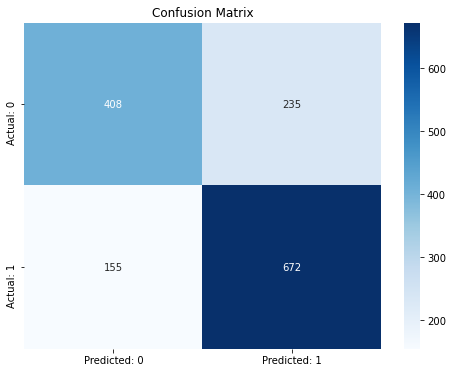

In [99]:
# Plot the Confusion Matrix
plt.figure(figsize = (8,6))
plt.title("Confusion Matrix")
sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap="Blues")
plt.savefig('../images/cm_final.png')

In [95]:
## probabilities of each obs being y=1
y_pred_probs_1 = y_pred_probs[:,1]

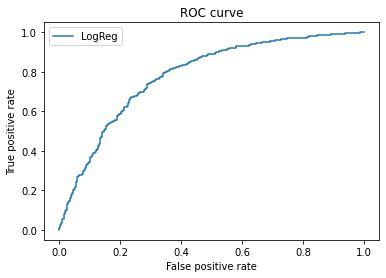

In [96]:
## ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs_1)

plt.plot(fpr, tpr, label='LogReg')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('../images/roc_curve_final.png')

# Feature importances

In [65]:
coef_names = feature_names[1:]
coef_names

['numerical__TestA',
 'numerical__TestB',
 'numerical__GeneD',
 'numerical__GeneE',
 'numerical__GeneF',
 'categorical__x0_female',
 'categorical__x0_non-female',
 'categorical__x1_negative',
 'categorical__x1_positive',
 'categorical__x2_active',
 'categorical__x2_not active']

In [76]:
coefs = final_model.coef_
coefs2 = np.transpose(coefs)

In [82]:
importances = pd.DataFrame(coefs2, index=coef_names, columns=['coefficient'])

In [84]:
## since coeffs represent log-odds
## we can calculate odds-ratio and probabilities using these values
import math 

def calc_odds(logodds):
    return math.exp(logodds)

def calc_prob(odds):
    return round((odds / (1 + odds)), 2)

In [85]:
importances['odds'] = importances['coefficient'].apply(calc_odds)
importances['probs'] = importances['odds'].apply(calc_prob)

In [87]:
importances

,coefficient,odds,probs
numerical__TestA,-0.123433,0.883881,0.47
numerical__TestB,-0.730919,0.481466,0.32
numerical__GeneD,-0.030721,0.969746,0.49
numerical__GeneE,-0.217352,0.804646,0.45
numerical__GeneF,-0.087701,0.916035,0.48
categorical__x0_female,1.233037,3.431636,0.77
categorical__x0_non-female,-0.914244,0.400820,0.29
categorical__x1_negative,0.206106,1.228883,0.55
categorical__x1_positive,0.000000,1.000000,0.50
categorical__x2_active,0.000000,1.000000,0.50


### Findings:
'GeneC' (active/not active) and 'blood_test' (negative/positive) don't seem to be relevant/significant at all?

# Approach 2: Use statsmodels and p-value approach for feature importances

In [129]:
columns = feature_names
df_to_model = pd.DataFrame(arr, columns=columns)
df_to_model

,numerical__treatment,numerical__TestA,numerical__TestB,numerical__GeneD,numerical__GeneE,numerical__GeneF,categorical__x0_female,categorical__x0_non-female,categorical__x1_negative,categorical__x1_positive,categorical__x2_active,categorical__x2_not active
0,0.0,4.334376,0.324374,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.361847,-0.213014,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,3.611842,-0.071740,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,-5.282537,-0.237121,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,2.787207,0.195470,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7345,1.0,2.442280,-0.062665,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
7346,1.0,-6.010248,-0.106109,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
7347,1.0,-0.196411,0.089482,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
7348,1.0,-4.116299,0.038430,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [130]:
model = sm.Logit(df_to_model['numerical__treatment'], df_to_model[coef_names])
res = model.fit()

res.summary()

Optimization terminated successfully.
         Current function value: 0.550430
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     numerical__treatment   No. Observations:                 7350
Model:                            Logit   Df Residuals:                     7341
Method:                             MLE   Df Model:                            8
Date:                  Wed, 24 Feb 2021   Pseudo R-squ.:                  0.1984
Time:                          12:52:56   Log-Likelihood:                -4045.7
converged:                         True   LL-Null:                       -5046.8
Covariance Type:              nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
numerical__TestA              -0.1269      0.007    -18.083      0.000      -0.141      -0.113
numerical__TestB              -1.0081      0.170     -5.942      0.000      -1.341      -0.676
numerical__GeneD              -0.0521      0.055     -0.952      0.341      -0.159       0.055
numerical__GeneE              -0.2517      0.055     -4.585      0.000      -0.359      -0.144
numerical__GeneF              -0.1436      0.055     -2.621      0.009      -0.251      -0.036
categorical__x0_female         1.2980        nan        nan        nan         nan         nan
categorical__x0_non-female    -0.8913        nan        nan        nan         nan         nan
categorical__x1_negative       0.3668      1e+06   3.65e-07      1.000   -1.97e+06    1.97e+06
categorical__x1_positive       0.0398      1e+06   3.96e-08      1.000   -1.97e+06    1.97e+06
categorical__x2_active         0.2111   1.81e+06   1.17e-07      1.000   -3.54e+06    3.54e+06
categorical__x2_not active     0.1955   1.81e+06   1.08e-07      1.000   -3.54e+06    3.54e+06
==============================================================================================
"""

In [131]:
df.head()

,treatment,gender,blood_test,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,non-female,negative,4.334376,0.324374,not active,1,1,0
1,0,female,negative,0.361847,-0.213014,active,1,0,0
2,1,female,positive,3.611842,-0.071740,not active,0,0,1
3,0,female,negative,-5.282537,-0.237121,active,0,0,0
4,0,female,negative,2.787207,0.195470,not active,0,1,1
